In [38]:

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import tqdm
#import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import timm
import torcheval 
import wandb
import torchvision
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import seaborn as sns
from albumentations.pytorch import ToTensorV2
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import psutil

In [39]:
RANDOM_NUMBER = 42
torch.manual_seed(RANDOM_NUMBER)

# select Device

In [40]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIRECTORY = os.path.join(os.getcwd(),"data")
torch.cuda.empty_cache()

In [41]:
class Config():

    BASE_DIR = os.path.join(os.getcwd() , 'data')
    train_df = pd.read_csv(BASE_DIR  +  '/train.csv')
    TRAIN_VAL_SPLIT_SIZE = 0.1
    TRAIN_BATCH_SIZE = 64
    VAL_BATCH_SIZE = 64

    LR_MAX = 1e-4 
    NUM_EPOCHS = 18
    TIM_NUM_CLASS =1408 # 768 swin
    NORMALIZE_TARGET = "log_transform_mean_std"   #"log_transform" #
    RANDOM_NUMBER = 42
    NUM_FLODS  = 5
    NUM_CLASSES = 6
    TRAITS_NAME = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]
    FOLD = 0 # Which fold to set as validation data
    IMAGE_SIZE =128
    TARGET_IMAGE_SIZE =  384
    T_MAX =        9
    LR_MODE = "step" # LR scheduler mode from one of "cos", "step", "exp"
    torch.manual_seed(RANDOM_NUMBER)
    INCLUDE_EXTRA_FEATURES = True
    EXTRA_FEATURES_NORMALIZATION = "standard_scalar"  #"min_max_normalization"  #
    WEIGHT_DECAY = 0.01
    TABULAR_NN_OUTPUT  = 256
    TIM_MODEL_NAME = "swin_large" #"efficientnet_v2" # 
    TIMM_FINED_TUNED_WEIGHT = f'{BASE_DIR}/model_08_ensemble.pth'
    Lower_Quantile = 0.005
    Upper_Quantile = 0.985
    # use XGBBOOST to find prominant features
    EXTRA_COLOUMN = ['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg',
       'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg',
       'SOIL_bdod_30.60cm_mean_0.01_deg',
       'SOIL_bdod_5.15cm_mean_0.01_deg',
       'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg',
       'SOIL_cec_100.200cm_mean_0.01_deg',
       'SOIL_cec_15.30cm_mean_0.01_deg', 'SOIL_cec_30.60cm_mean_0.01_deg',
       'SOIL_cec_5.15cm_mean_0.01_deg', 'SOIL_cec_60.100cm_mean_0.01_deg',
       'SOIL_cfvo_0.5cm_mean_0.01_deg',
       'SOIL_cfvo_100.200cm_mean_0.01_deg',
       'SOIL_cfvo_15.30cm_mean_0.01_deg',
       'SOIL_cfvo_30.60cm_mean_0.01_deg',
       'SOIL_cfvo_5.15cm_mean_0.01_deg',
       'SOIL_cfvo_60.100cm_mean_0.01_deg',
       'SOIL_clay_0.5cm_mean_0.01_deg',
       'SOIL_clay_100.200cm_mean_0.01_deg',
       'SOIL_clay_15.30cm_mean_0.01_deg',
       'SOIL_clay_30.60cm_mean_0.01_deg',
       'SOIL_clay_5.15cm_mean_0.01_deg',
       'SOIL_clay_60.100cm_mean_0.01_deg',
       'SOIL_nitrogen_0.5cm_mean_0.01_deg',
       'SOIL_nitrogen_100.200cm_mean_0.01_deg',
       'SOIL_nitrogen_15.30cm_mean_0.01_deg',
       'SOIL_nitrogen_30.60cm_mean_0.01_deg',
       'SOIL_nitrogen_5.15cm_mean_0.01_deg',
       'SOIL_nitrogen_60.100cm_mean_0.01_deg',
       'SOIL_ocd_0.5cm_mean_0.01_deg', 'SOIL_ocd_100.200cm_mean_0.01_deg',
       'SOIL_ocd_15.30cm_mean_0.01_deg', 'SOIL_ocd_30.60cm_mean_0.01_deg',
       'SOIL_ocd_5.15cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
       'SOIL_ocs_0.30cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg',
       'SOIL_phh2o_100.200cm_mean_0.01_deg',
       'SOIL_phh2o_15.30cm_mean_0.01_deg',
       'SOIL_phh2o_30.60cm_mean_0.01_deg',
       'SOIL_phh2o_5.15cm_mean_0.01_deg',
       'SOIL_phh2o_60.100cm_mean_0.01_deg',
       'SOIL_sand_0.5cm_mean_0.01_deg',
       'SOIL_sand_100.200cm_mean_0.01_deg',
       'SOIL_sand_15.30cm_mean_0.01_deg',
       'SOIL_sand_30.60cm_mean_0.01_deg',
       'SOIL_sand_5.15cm_mean_0.01_deg',
       'SOIL_sand_60.100cm_mean_0.01_deg',
       'SOIL_silt_0.5cm_mean_0.01_deg',
       'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg',
       'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg',
       'SOIL_silt_60.100cm_mean_0.01_deg', 'SOIL_soc_0.5cm_mean_0.01_deg',
       'SOIL_soc_100.200cm_mean_0.01_deg',
       'SOIL_soc_15.30cm_mean_0.01_deg', 'SOIL_soc_30.60cm_mean_0.01_deg',
       'SOIL_soc_5.15cm_mean_0.01_deg', 'SOIL_soc_60.100cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9',
       'VOD_C_2002_2018_multiyear_mean_m01',
       'VOD_C_2002_2018_multiyear_mean_m02',
       'VOD_C_2002_2018_multiyear_mean_m03',
       'VOD_C_2002_2018_multiyear_mean_m04',
       'VOD_C_2002_2018_multiyear_mean_m05',
       'VOD_C_2002_2018_multiyear_mean_m06',
       'VOD_C_2002_2018_multiyear_mean_m07',
       'VOD_C_2002_2018_multiyear_mean_m08',
       'VOD_C_2002_2018_multiyear_mean_m09',
       'VOD_C_2002_2018_multiyear_mean_m10',
       'VOD_C_2002_2018_multiyear_mean_m11',
       'VOD_C_2002_2018_multiyear_mean_m12',
       'VOD_Ku_1987_2017_multiyear_mean_m01',
       'VOD_Ku_1987_2017_multiyear_mean_m02',
       'VOD_Ku_1987_2017_multiyear_mean_m03',
       'VOD_Ku_1987_2017_multiyear_mean_m04',
       'VOD_Ku_1987_2017_multiyear_mean_m05',
       'VOD_Ku_1987_2017_multiyear_mean_m06',
       'VOD_Ku_1987_2017_multiyear_mean_m07',
       'VOD_Ku_1987_2017_multiyear_mean_m08',
       'VOD_Ku_1987_2017_multiyear_mean_m09',
       'VOD_Ku_1987_2017_multiyear_mean_m10',
       'VOD_Ku_1987_2017_multiyear_mean_m11',
       'VOD_Ku_1987_2017_multiyear_mean_m12',
       'VOD_X_1997_2018_multiyear_mean_m01',
       'VOD_X_1997_2018_multiyear_mean_m02',
       'VOD_X_1997_2018_multiyear_mean_m03',
       'VOD_X_1997_2018_multiyear_mean_m04',
       'VOD_X_1997_2018_multiyear_mean_m05',
       'VOD_X_1997_2018_multiyear_mean_m06',
       'VOD_X_1997_2018_multiyear_mean_m07',
       'VOD_X_1997_2018_multiyear_mean_m08',
       'VOD_X_1997_2018_multiyear_mean_m09',
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12'
       ]

    
    # EXTRA_COLOUMN =['VOD_C_2002_2018_multiyear_mean_m06',
    # 'VOD_C_2002_2018_multiyear_mean_m01',
    # 'SOIL_nitrogen_100.200cm_mean_0.01_deg',
    # 'SOIL_nitrogen_0.5cm_mean_0.01_deg',
    # 'SOIL_soc_0.5cm_mean_0.01_deg',
    # 'SOIL_ocd_0.5cm_mean_0.01_deg',
    # 'SOIL_bdod_0.5cm_mean_0.01_deg',
    # 'SOIL_soc_100.200cm_mean_0.01_deg',
    # 'WORLDCLIM_BIO15_precipitation_seasonality',
    # 'SOIL_bdod_100.200cm_mean_0.01_deg',
    # 'SOIL_ocd_100.200cm_mean_0.01_deg',
    # 'SOIL_ocd_30.60cm_mean_0.01_deg',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5',
    # 'SOIL_phh2o_0.5cm_mean_0.01_deg',
    # 'WORLDCLIM_BIO12_annual_precipitation',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7',
    # 'WORLDCLIM_BIO4_temperature_seasonality',
    # 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
    # 'WORLDCLIM_BIO1_annual_mean_temperature',
    # 'SOIL_cfvo_0.5cm_mean_0.01_deg',
    # 'SOIL_clay_100.200cm_mean_0.01_deg',
    # 'SOIL_clay_0.5cm_mean_0.01_deg',
    # 'SOIL_silt_0.5cm_mean_0.01_deg',
    # 'SOIL_sand_0.5cm_mean_0.01_deg',
    # 'SOIL_cec_15.30cm_mean_0.01_deg',
    # 'SOIL_cec_100.200cm_mean_0.01_deg',
    # 'SOIL_cec_0.5cm_mean_0.01_deg',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4']
    N_TARGETS  =len(TRAITS_NAME)  


CONFIG = Config()



In [42]:

from sklearn.preprocessing import StandardScaler , MinMaxScaler
SCALAR = None

def create_val_train_dataset(BASE_DIR,train_split_size):
    global SCALAR
    df = pd.read_csv(BASE_DIR  +  '/train.csv')
    if CONFIG.INCLUDE_EXTRA_FEATURES :
        df = df[["id"] +CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME]
        df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training datafram
    else :  
        df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df = df[["id"] + ["image_path"] + CONFIG.TRAITS_NAME ]
    
    # do the normalization
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        print(CONFIG.EXTRA_FEATURES_NORMALIZATION)
        if CONFIG.EXTRA_FEATURES_NORMALIZATION == "standard_scalar":
            SCALAR = StandardScaler()
            SCALAR.fit(df[CONFIG.EXTRA_COLOUMN])
            df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])
        elif CONFIG.EXTRA_FEATURES_NORMALIZATION == "min_max_normalization":
            SCALAR = MinMaxScaler()
            # standardize the dataset ( tabular dataset )
            SCALAR.fit(df[CONFIG.EXTRA_COLOUMN])
            df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])
    
    
    
    train_df , val_df = train_test_split(df,test_size=train_split_size,shuffle=True)
    print(f"before removing the outliers Num Train: {len(train_df)} | Num Valid: {len(val_df)}")
    # upper_quantiles = train_df[CONFIG.TRAITS_NAME].quantile(0.98)
    # retained_flag = (train_df[CONFIG.TRAITS_NAME] < upper_quantiles).all(axis= 1) & (train_df[CONFIG.TRAITS_NAME] > 0).all(axis=1)
    # train_df = train_df[retained_flag]
    
    #train_df = train_df[(np.abs(stats.zscore(np.log10(train_df[CONFIG.TRAITS_NAME]))<3).all(axis=1)  )]
    
    # lower_quantile = train_df[CONFIG.TRAITS_NAME].quantile(CONFIG.Lower_Quantile)
    # upper_quantile = train_df[CONFIG.TRAITS_NAME].quantile(CONFIG.Upper_Quantile)
    # train_df = train_df[(train_df[CONFIG.TRAITS_NAME] >= lower_quantile) & (train_df[CONFIG.TRAITS_NAME] <= upper_quantile)]
    for column in CONFIG.TRAITS_NAME:
        lower_quantile = train_df[column].quantile(CONFIG.Lower_Quantile)
        upper_quantile = train_df[column].quantile(CONFIG.Upper_Quantile)
        train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]
    train_df.reset_index(drop=True , inplace  = True)
    val_df.reset_index(drop = True , inplace = True)
    
    print(f"after removing the outliers Num Train: {len(train_df)} | Num Valid: {len(val_df)}")

        
    return  train_df , val_df



def create_test_dataset(BASE_DIR):
    global SCALAR
    df = pd.read_csv(BASE_DIR  +  '/test.csv')
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        #print(df.columns)
        df = df[["id"] +CONFIG.EXTRA_COLOUMN]
        df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df[CONFIG.EXTRA_COLOUMN] = SCALAR.transform(df[CONFIG.EXTRA_COLOUMN])   
    else :
        df = df[["id"] +CONFIG.EXTRA_COLOUMN ]
        df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
        df = df[["id"] + ["image_path"] ]
    return df

train_df , val_df = create_val_train_dataset(CONFIG.BASE_DIR,CONFIG.TRAIN_VAL_SPLIT_SIZE)
test_df = create_test_dataset(CONFIG.BASE_DIR)

# some hyper parameter for lr scheduler
CONFIG.N_TRAIN_SAMPLES = len(train_df)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.TRAIN_BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.NUM_EPOCHS + 1

standard_scalar
before removing the outliers Num Train: 39026 | Num Valid: 4337
after removing the outliers Num Train: 34577 | Num Valid: 4337


/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

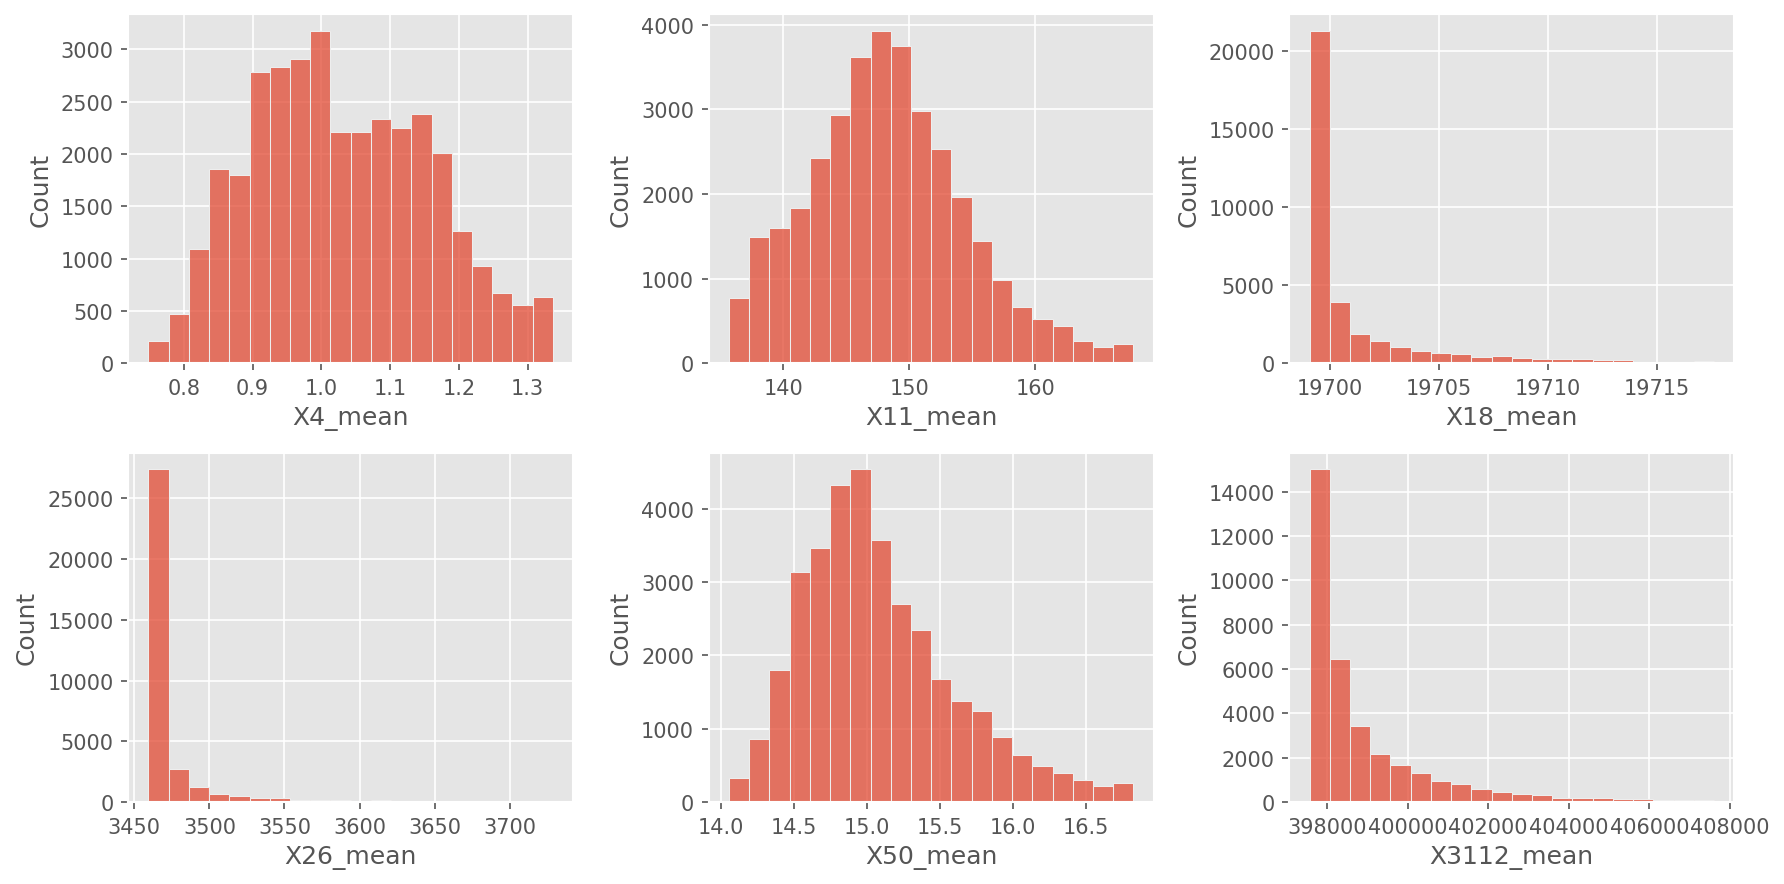

In [43]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(CONFIG.TRAITS_NAME):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=train_df, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()

# DATALOADER 

In [44]:
class NormalizeTarget():
    def __init__(self,type_transform ):
        self.transform = type_transform
        self.mean = 0
        self.std = 0
        self.mean_tensor = 0
        self.std_tensor = 0
        
    def normalize(self,df):
        if self.transform == "log_transform":
            mean = np.log10(df).mean()
            std = np.log10(df).std()
            min =  np.log10(df).min()
            max = np.log10(df).max()
            
            self.min  = min
            self.max = max
            
            self.mean = mean
            self.std = std
            
            self.min_tensor = torch.Tensor(self.min.values).to(DEVICE)
            self.max_tensor = torch.Tensor(self.max.values).to(DEVICE)
            
            self.mean_tensor = torch.Tensor(self.mean.values).to(DEVICE)
            self.std_tensor = torch.Tensor(self.std.values).to(DEVICE)
            
            tf = (np.log10(df) - self.min)/(self.max - self.min)
        elif self.transform == "log_transform_mean_std": 
            tf = (np.log10(df) - self.mean)/(self.std) 
        elif self.transform == None:
            tf = df
        return tf 
    def denormalize(self,df):
        if self.mean is None or self.std is None :
            raise Exception("mean and/std is not defined ")
        if self.transform  == "log_transform":
            df_denormalize =10**((df*(self.max - self.min)) + self.min )
            return df_denormalize
        if self.transform  =="log_transform_mean_std":
            df_denormalize =10**((df*self.std) + self.mean )
            return df_denormalize
        elif self.transform == None:
            df_denormalize = df
            return df_denormalize
        
    def denormalize_tensor(self,batch) :
        if self.mean_tensor is None or self.std_tensor is None :
            raise Exception("mean and/std is not defined ")
        if self.transform == "log_transform":
            df_denormalize =10**((batch*(self.max_tensor - self.min_tensor)) + self.min_tensor )
        elif self.transform == "log_transform_mean_std":
            df_denormalize =10**((batch*self.std_tensor) + self.mean_tensor )
        elif self.transform == None:
            df_denormalize = batch
        return df_denormalize
NormalizeTarget_obj = NormalizeTarget(CONFIG.NORMALIZE_TARGET)

In [45]:
class data_loader( Dataset ):
    def __init__(self,df , is_val = False):
        self.df = df.copy()
        self.is_val = is_val
        if CONFIG.NORMALIZE_TARGET == None:
            pass
        else:
            if not is_val :
                self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]] = NormalizeTarget_obj.normalize(self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]])
        

        self.train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(
            [50,50],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.75),
        A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
        A.ToFloat(),
        A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
        ToTensorV2(),
                    ])       
        
        # self.train_transform  = A.Compose([
        #     #A.CLAHE(p=0.1),
        #     #A.RandomRotate90(p=0.1),
        #     #A.Transpose(p=0.4),
        #     #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        #     #A.Blur(blur_limit=3,p=0.1),
        #     #A.OpticalDistortion(p=0.1),
        #     #A.GridDistortion(p=0.3),
        #     A.HueSaturationValue(p=0.3),
        #     A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_LINEAR,p=1),
        #     A.ToFloat(),
        #     A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
        #     ToTensorV2(),
        #     ])
        
        self.val_transform = A.Compose([
                A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_CUBIC),
                A.ToFloat(),
                    A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
                    ToTensorV2(),
        ])
        self.extra_params = CONFIG.INCLUDE_EXTRA_FEATURES
        self.extra_coloumns = CONFIG.EXTRA_COLOUMN
    
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self , index):
        row = self.df.iloc[index]
        image = plt.imread(row["image_path"])
        #image = np.copy(image)
        traits = row[CONFIG.TRAITS_NAME].values.astype(np.float32)
        traits = torch.tensor(traits,dtype=torch.float32)
        if not self.is_val:
            image = self.train_transform(image = image)["image"]
            #image = torch.permute(image  )
        else:
            image = self.val_transform(image = image)["image"]
            
        if self.extra_params:
            extras = row[self.extra_coloumns].values.astype(np.float32)
            return image , traits  , torch.tensor(extras,dtype=torch.float32)
        return  image , traits



train_dataset = data_loader(train_df, is_val = False )
val_dataset  = data_loader(val_df,   is_val = True)    

train_dataloader = DataLoader(train_dataset , batch_size = CONFIG.TRAIN_BATCH_SIZE , shuffle=True,drop_last=True)
val_dataloader = DataLoader(val_dataset , batch_size =  CONFIG.VAL_BATCH_SIZE , shuffle=False,drop_last=True)


In [46]:
class ImageBackbone_swin(nn.Module):
    def __init__(self, backbone_name, weight_path, out_features, fixed_feature_extractor=False):
        super().__init__()
        self.out_features = out_features
        self.backbone = timm.create_model('swin_large_patch4_window12_384.ms_in22k_ft_in1k', pretrained=False, num_classes=CONFIG.N_TARGETS)
        self.backbone.load_state_dict(torch.load(weight_path))
        if fixed_feature_extractor:
            for param in self.backbone.parameters():
                param.requires_grad = False
        in_features = self.backbone.num_features
        
        self.backbone.head = nn.Identity()
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_features, out_features),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        return self.head(x)
    
    
class TabularBackbone(nn.Module):
    def __init__(self, n_features, out_features):
        super().__init__()
        self.out_features = out_features
        self.fc = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        return self.fc(x)    



# Define Model

In [47]:
def initialize_timm_model( model_name   , tim_num_class=0.0, fine_tuned_weight = None,fixed_feature_extractor=True):
    model_ft  = None
    if model_name == "resnet34" :
        """ Resnet34 """
        model = timm.create_model('resnet34' , num_classes=tim_num_class )
        return model
    if model_name == "Swin_Transformer":
        model = timm.create_model('swin_tiny_patch4_window7_224.ms_in22k' , pretrained=True , num_classes = tim_num_class)
        return model 
    if model_name == "swin_large":
        if fine_tuned_weight!=None:
            model = ImageBackbone_swin(model_name,fine_tuned_weight , tim_num_class,fixed_feature_extractor)
        else:
            model = timm.create_model('swin_large_patch4_window12_384.ms_in22k_ft_in1k',pretrained=True, num_classes = tim_num_class)
            #model.load_state_dict(torch.load(weight_path))
            model.head.drop = nn.Dropout(p=0.1,inplace=False)
        return model
    if model_name =="convnextv2":
        model = timm.create_model('convnext_tiny.in12k_ft_in1k_384',num_classes=tim_num_class)
        return model     
    if model_name == "efficientnet_v2":
        model = timm.create_model("efficientnet_b2.ra_in1k",pretrained = True)
        model.classifier = nn.Dropout(p=0.2,inplace=False)
        return model
    if model_name == "vit":
        model = timm.create_model('vit_base_patch16_224.augreg2_in21k_ft_in1k', pretrained=True)
        # get model specific transforms (normalization, resize)
        data_config = timm.data.resolve_model_data_config(model)
        transforms = timm.data.create_transform(**data_config, is_training=False)
        return model


# tm_model = initialize_timm_model("swin_large",tim_num_class=CONFIG.TIM_NUM_CLASS)
# data_config = timm.data.resolve_model_data_config(tm_model)
# transforms = timm.data.create_transform(**data_config, is_training=True)


In [48]:
class CustomModel(nn.Module):
    def __init__(self,input_channels,out_channels, target_features_num , tim_num_class , model_name):
        super().__init__()
        self.img_backbone = initialize_timm_model(model_name=model_name ,tim_num_class=tim_num_class , fine_tuned_weight = CONFIG.TIMM_FINED_TUNED_WEIGHT,fixed_feature_extractor=True)
        self.extra_features_model = TabularBackbone(n_features  = len(CONFIG.EXTRA_COLOUMN) , out_features=128)
        self.fc = nn.Sequential(
            nn.Linear(self.extra_features_model.out_features + self.img_backbone.out_features, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(256, target_features_num),
        )        
    def forward(self,image,x):
        output_image = self.img_backbone(image) # bach * (hight*col)
        z = self.extra_features_model(x) # batch * 16
        inputs  = torch.cat((output_image,z), 1 )
        output = self.fc(inputs)
        return output
class BestModelSaveCallback:
    def __init__(self, save_path):
        self.save_path = save_path
        self.best_accuracy = -1

    def __call__(self, accuracy,model):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            model.to(device = "cpu")
            torch.save(model.state_dict(), self.save_path)
            model.to(device=DEVICE)


In [49]:

if CONFIG.INCLUDE_EXTRA_FEATURES:
    model = CustomModel(input_channels = len(CONFIG.EXTRA_COLOUMN) ,out_channels =CONFIG.TABULAR_NN_OUTPUT, target_features_num= len(CONFIG.TRAITS_NAME), tim_num_class=CONFIG.TIM_NUM_CLASS , model_name=CONFIG.TIM_MODEL_NAME)
else:
    model = initialize_timm_model(model_name=CONFIG.TIM_MODEL_NAME , tim_num_class = len(CONFIG.TRAITS_NAME) )    
model.to(device = DEVICE)


/tmp/ipykernel_102666/3968005602.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.backbone.load_state_dict(torch.load(weight_path))


CustomModel(
  (img_backbone): ImageBackbone_swin(
    (backbone): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=192, out_features=576, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=192, out_features=192, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path1): Identity()
              (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        

In [50]:
# img = torch.ones(4,3,384,384).to('cuda')
# features = torch.ones(4,len(CONFIG.EXTRA_COLOUMN)).to('cuda')
# model(img,features).shape

# Define Loss Metric for the Model and MISC

In [51]:
# optimizer
import torcheval.metrics
import torcheval.metrics.regression


optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

# lr scheduler
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )
    
    
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count
        
MSE = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
R2sc = torcheval.metrics.regression.R2Score(num_regressors=len(CONFIG.TRAITS_NAME) , multioutput="uniform_average").to(DEVICE)
R2sc_val = torcheval.metrics.regression.R2Score(num_regressors=len(CONFIG.TRAITS_NAME) , multioutput="uniform_average").to(DEVICE)
MSE_val = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
LOSS = AverageMeter()
LOSS_val = AverageMeter()
TARGET_TRAITS_MEAN = torch.tensor(train_df[CONFIG.TRAITS_NAME].mean().values).to(DEVICE)        # target mean accross the training dataset
EPS = torch.tensor([1e-6]).to('cuda')


# just to check if r2 loss is also decreasing 
def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - TARGET_TRAITS_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

LOSS_FN = nn.SmoothL1Loss() # r2_loss
LR_SCHEDULER = get_lr_scheduler(optimizer)

In [52]:
# MSE = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
# y_pred = torch.ones(13,6).to(DEVICE)
# y = torch.randn(13,6).to(DEVICE)
# MSE.update(y_pred,y)
# MSE.compute().item()

In [53]:
# y_pred = torch.ones(13,6).to(DEVICE)
# y = torch.randn(13,6).to(DEVICE)
# MSE.update(y_pred,y)
# MSE.compute().item()

In [54]:
def train_batch(inputs,model):
    model.train()  
    if CONFIG.INCLUDE_EXTRA_FEATURES :
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        y_pred = model(x,z)        
        
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)    
        y_pred = model(x)
    
    
    #loss_func = nn.MSELoss()
    #loss_val = loss_func(prediction,y)
    loss = LOSS_FN(y_pred,y) 
    LOSS.update(loss)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    LR_SCHEDULER.step()
    MSE.update(y_pred,y)
    R2sc.update(y_pred , y )
    return LOSS.avg.detach().cpu().numpy() ,MSE.compute().item() ,R2sc.compute().item()

@torch.no_grad
def do_prediction(inputs,model, is_val=False):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if  CONFIG.INCLUDE_EXTRA_FEATURES:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    if is_val :
        prediction = NormalizeTarget_obj.denormalize_tensor(batch=prediction)


@torch.no_grad()
def validation_loss_batch(inputs,model):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    prediction = NormalizeTarget_obj.denormalize_tensor(batch=prediction)
    loss = LOSS_FN(prediction, y)
    LOSS_val.update(loss)
    MSE_val.update(prediction,y)
    R2sc_val.update(prediction , y )
    return LOSS_val.avg.detach().cpu().numpy() ,MSE_val.compute().item() ,R2sc_val.compute().item()

def utils_convert_to_2d_tensors(predictions,targets):
    predictions  = np.array(predictions)
    targets = np.array(targets)
    predictions  = np.reshape(predictions , (-1, predictions.shape[-1]))
    targets  = np.reshape(targets  , (-1 , targets.shape[-1]))
    return torch.Tensor(predictions), torch.Tensor(targets)

def train(trainLoader,valLoader,model,num_epochs,best_model_callback):
    #wandb.watch(model,loss_function,log = "all",log_freq=50)
    
    train_epoch_loss , train_epoch_r2 , train_epoch_mse =[] , [] , []
    val_epoch_loss , val_epoch_r2 , val_epoch_mse = [],[],[]
    
    
    for epoch in range(num_epochs):
        # print(f"epoch: {epoch} , lr is { LR_SCHEDULER.get_last_lr()}" )
        train_loss_current_epoch ,train_mse_current_epoch, train_r2_current_epoch = [] , [] , []
        MSE.reset()
        R2sc.reset()
        LOSS.reset()
        # batch training loss
        with tqdm.tqdm(total=len(trainLoader)) as trainingLoop:
            for index,batch in enumerate(iter(trainLoader)): 
        
                loss,mse_ , r2_ = train_batch(batch,model)
                train_loss_current_epoch.append(loss)
                train_mse_current_epoch.append(mse_)
                train_r2_current_epoch.append(r2_)
                
                trainingLoop.set_description(f"Epoch:{epoch} , Batch: {index}/{len(trainLoader)} ")
                #print(loss , mse_,  r2_ ,LR_SCHEDULER.get_last_lr())
                trainingLoop.set_postfix({ "batch" : index , "loss is" : loss , "MSE" :  mse_ , "R2":  r2_, "lr was":  LR_SCHEDULER.get_last_lr()[0] })
                trainingLoop.update(1)
                ##wandb.log({"Training Loss":loss })
        
        # train_epoch_loss.append(np.array(train_loss_current_epoch).mean() )
        # train_epoch_r2.append(np.array(train_r2_current_epoch).mean())
        # train_epoch_mse.append(np.array(train_mse_current_epoch).mean())

        MSE_val.reset()
        R2sc_val.reset()
        LOSS_val.reset()
                
        # validation set loss & accuracy  
        val_loss_current_epoch ,val_mse_current_epoch, val_r2_current_epoch = [] , [] , []
        with tqdm.tqdm(total = len(valLoader)) as validationLoop:
            for index,batch in enumerate(iter(valLoader)):
                loss,mse_ , r2_ = validation_loss_batch(batch,model)
                val_loss_current_epoch.append(loss)
                val_mse_current_epoch.append(mse_) 
                val_r2_current_epoch.append(r2_)
                validationLoop.set_description(f"Batch: {index}/{len(valLoader)}")
                validationLoop.set_postfix({ "batch" : index , "loss is" : loss , "MSE" :  mse_ , "R2":  r2_ })
                ##wandb.log({"Vlaidation loss" : loss})
                #wandb.log({"Validation Loss ": val_loss.item()})
                validationLoop.update(1)



        # val_epoch_loss.append(np.array(val_loss_current_epoch).mean())
        val_epoch_r2.append(np.array(r2_).mean())
        # val_epoch_mse.append(np.array(mse_).mean())
        
        # print(f"epoch:{epoch}, Training (avg) loss : {train_epoch_loss[-1]} , Validation loss (avg) = {val_epoch_loss[-1]}")
        # print(f"epoch:{epoch}, Training (avg) r2 : {train_epoch_r2[-1]} , Validation r2(avg) = {val_epoch_r2[-1]}")
        
        best_model_callback(val_epoch_r2[-1],model)        # save the best model according to the validation accuracy
        
        
    return train_epoch_loss,val_epoch_loss,train_epoch_r2 , val_epoch_r2


In [55]:

MODEL_NAME_SAVE = 'best_model_transformation_efficientnet_copy.pth'
best_model_callback = BestModelSaveCallback(save_path=os.path.join(CONFIG.BASE_DIR,MODEL_NAME_SAVE))
train_losses, val_losses , train_accuracies,val_accuracies = train(train_dataloader,val_dataloader,model,CONFIG.NUM_EPOCHS,best_model_callback)

Epoch:0 , Batch: 130/540 :  24%|██▍       | 131/540 [04:53<15:15,  2.24s/it, batch=130, loss is=inf, MSE=inf, R2=nan, lr was=1.4e-5] 


KeyboardInterrupt: 